In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors

# Load the Data

In [3]:
# Load the data
traffic_data_path = '/content/drive/MyDrive/ev_charging_analysis/traffic_san_francisco.csv'
osm_data_path = '/content/drive/MyDrive/ev_charging_analysis/osm_san_francisco.csv'
osm_features_path = '/content/drive/MyDrive/ev_charging_analysis/osm_features_san_francisco.csv'
charging_stations_path = '/content/drive/MyDrive/ev_charging_analysis/charging_stations_san_francisco.csv'

In [4]:
charging_stations = pd.read_csv(charging_stations_path)
traffic_data = pd.read_csv(traffic_data_path)
osm_data = pd.read_csv(osm_data_path)
osm_features = pd.read_csv(osm_features_path)

# Geospatial merging

In [5]:
# Convert dataframes to geodataframes
gdf_stations = gpd.GeoDataFrame(charging_stations, geometry=gpd.points_from_xy(charging_stations.longitude, charging_stations.latitude))
gdf_traffic = gpd.GeoDataFrame(traffic_data, geometry=gpd.points_from_xy(traffic_data.longitude, traffic_data.latitude))

# Spatial join - nearest method
joined_data = gpd.sjoin_nearest(gdf_stations, gdf_traffic, max_distance=500, distance_col="distances")  # 500 meters tolerance

In [6]:
joined_data.head()

,latitude_left,longitude_left,station_name,street_address,city,state,zip,num_points,operator,usage_cost,geometry,index_right,latitude_right,longitude_right,current_speed,free_flow_speed,confidence,congestion_level,distances
0,37.774142,-122.418547,City of San Francisco - 49 SVN,49 S Van Ness Ave,San Francisco,CA,94102,1,Unknown,Not specified,POINT (-122.41855 37.77414),10,37.76898,-122.380629,22,22,1,100.0,0.038268
1,37.775745,-122.418191,HUDSON PACIFIC 1455 LOBBY 1,1455 Market St,San Francisco,CA,94103,2,Unknown,Not specified,POINT (-122.41819 37.77574),10,37.76898,-122.380629,22,22,1,100.0,0.038167
2,37.774933,-122.417260,HUDSON PACIFIC 1455 STATION 1,1455 Market Street,San Francisco,CA,94103,1,Unknown,Not specified,POINT (-122.41726 37.77493),10,37.76898,-122.380629,22,22,1,100.0,0.037112
3,37.774846,-122.417113,HUDSON PACIFIC 1455 STATION 10,1455 Market Street,San Francisco,CA,94103,1,Unknown,Not specified,POINT (-122.41711 37.77485),10,37.76898,-122.380629,22,22,1,100.0,0.036953
4,37.776736,-122.418958,100 Van Ness - Garage - B1,100 Van Ness Avenue,San Francisco,CA,94102,1,Unknown,Not specified,POINT (-122.41896 37.77674),10,37.76898,-122.380629,22,22,1,100.0,0.039106


In [7]:
print(joined_data.describe())

       latitude_left  longitude_left   num_points  index_right  \
count    1000.000000     1000.000000  1000.000000  1000.000000   
mean       37.759527     -122.363691     1.227000    11.570000   
std         0.121451        0.102729     0.563728     8.585383   
min        37.511339     -122.697106     0.000000     0.000000   
25%        37.665155     -122.419970     1.000000     3.000000   
50%        37.779943     -122.390884     1.000000    11.000000   
75%        37.820566     -122.285248     1.000000    15.500000   
max        38.025507     -122.088746     5.000000    30.000000   

       latitude_right  longitude_right  current_speed  free_flow_speed  \
count     1000.000000      1000.000000    1000.000000      1000.000000   
mean        37.768433      -122.367243      52.035000        62.156000   
std          0.095146         0.078660      34.189072        32.940655   
min         37.640314      -122.678077      19.000000        22.000000   
25%         37.672481      -122.380

In [8]:
print(joined_data.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   latitude_left     1000 non-null   float64 
 1   longitude_left    1000 non-null   float64 
 2   station_name      1000 non-null   object  
 3   street_address    1000 non-null   object  
 4   city              1000 non-null   object  
 5   state             1000 non-null   object  
 6   zip               996 non-null    object  
 7   num_points        1000 non-null   int64   
 8   operator          1000 non-null   object  
 9   usage_cost        996 non-null    object  
 10  geometry          1000 non-null   geometry
 11  index_right       1000 non-null   int64   
 12  latitude_right    1000 non-null   float64 
 13  longitude_right   1000 non-null   float64 
 14  current_speed     1000 non-null   int64   
 15  free_flow_speed   1000 non-null   int64   
 16  confidence        1000

# Handle Missing Values

In [9]:
joined_data.isnull().sum()

,0
latitude_left,0
longitude_left,0
station_name,0
street_address,0
city,0
state,0
zip,4
num_points,0
operator,0
usage_cost,4


In [10]:
# Impute missing 'zip' with the most common value
most_common_zip = joined_data['zip'].mode()[0]
joined_data['zip'].fillna(most_common_zip, inplace=True)

<ipython-input-10-ab7c4a38954b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_data['zip'].fillna(most_common_zip, inplace=True)


In [11]:
# Set missing 'usage_cost' to 'Not specified'
joined_data['usage_cost'].fillna('Not specified', inplace=True)

<ipython-input-11-8b2c6639782b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_data['usage_cost'].fillna('Not specified', inplace=True)


In [12]:
joined_data.isnull().sum()

,0
latitude_left,0
longitude_left,0
station_name,0
street_address,0
city,0
state,0
zip,0
num_points,0
operator,0
usage_cost,0


# Feature Engineering

In [13]:
joined_data['latitude'] = joined_data[['latitude_left', 'latitude_right']].mean(axis=1)
joined_data['longitude'] = joined_data[['longitude_left', 'longitude_right']].mean(axis=1)

joined_data.drop(columns=['latitude_left', 'longitude_left', 'latitude_right', 'longitude_right'], inplace=True)

In [14]:
joined_data.columns

Index(['station_name', 'street_address', 'city', 'state', 'zip', 'num_points',
       'operator', 'usage_cost', 'geometry', 'index_right', 'current_speed',
       'free_flow_speed', 'confidence', 'congestion_level', 'distances',
       'latitude', 'longitude'],
      dtype='object')

# One-hot encoding categorical features

In [15]:
joined_data = pd.get_dummies(joined_data, columns=['city', 'usage_cost'])

# Normalize the features

In [16]:
features = joined_data[['latitude', 'longitude', 'current_speed', 'free_flow_speed', 'congestion_level', 'num_points', 'distances'] + list(joined_data.columns[joined_data.columns.str.startswith('city_')]) + list(joined_data.columns[joined_data.columns.str.startswith('operator_')]) + list(joined_data.columns[joined_data.columns.str.startswith('usage_cost_')])]


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# EDA

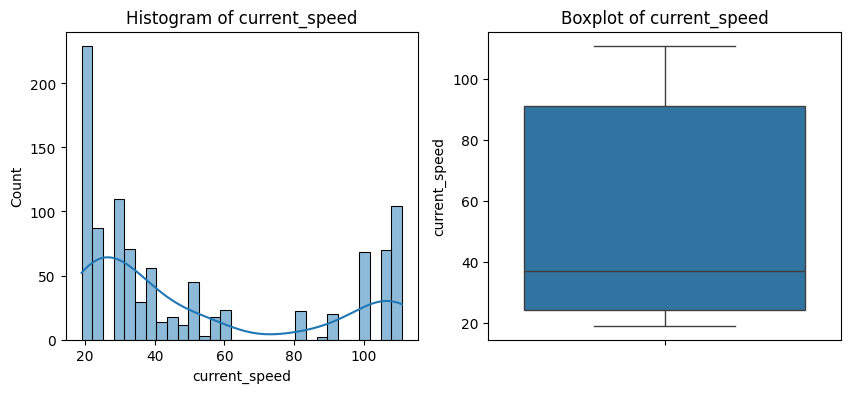

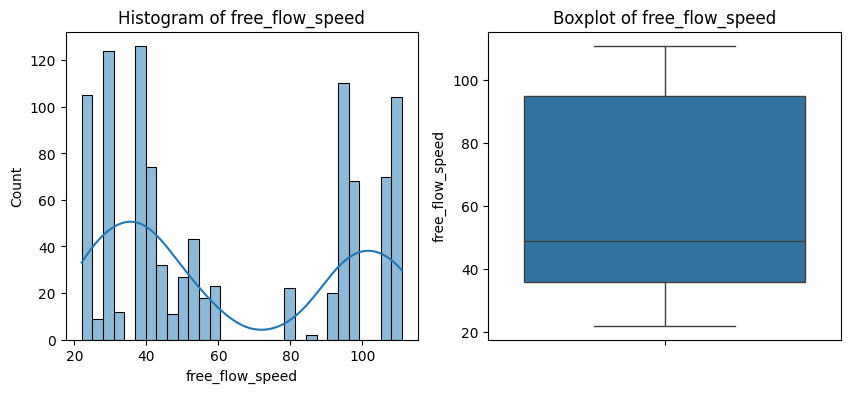

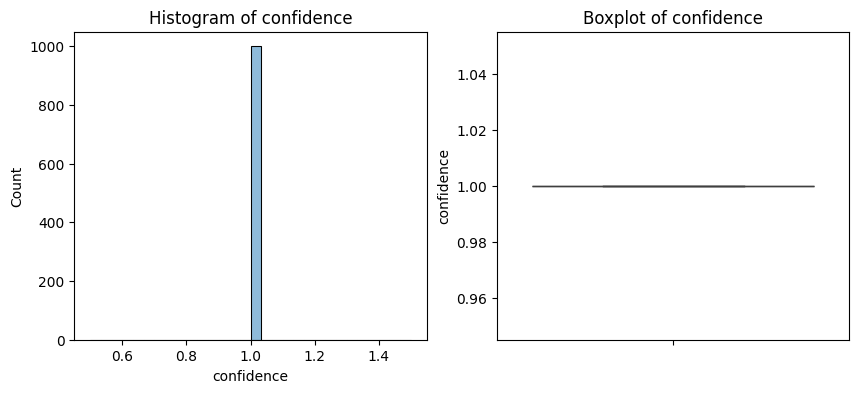

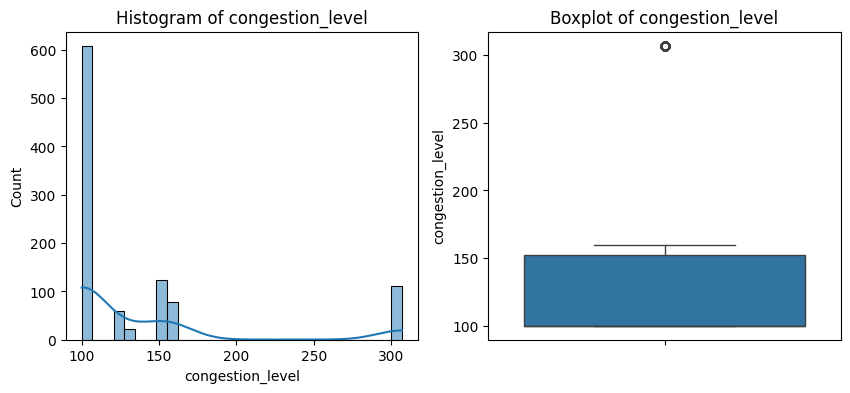

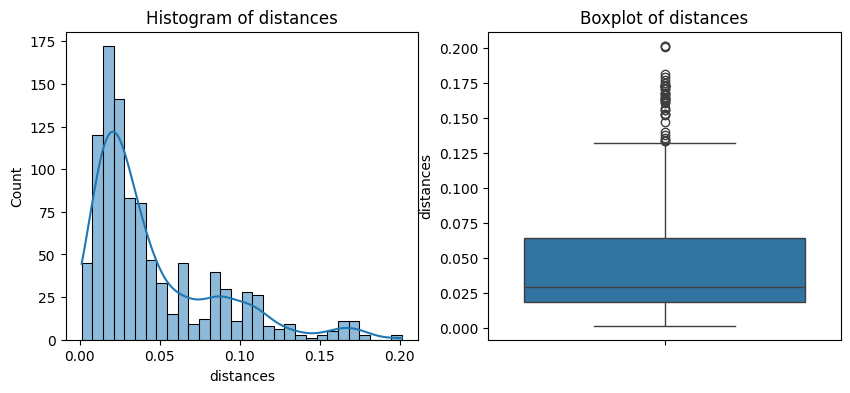

In [17]:
numerical_cols = ['current_speed', 'free_flow_speed', 'confidence', 'congestion_level', 'distances']

for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(joined_data[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=joined_data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

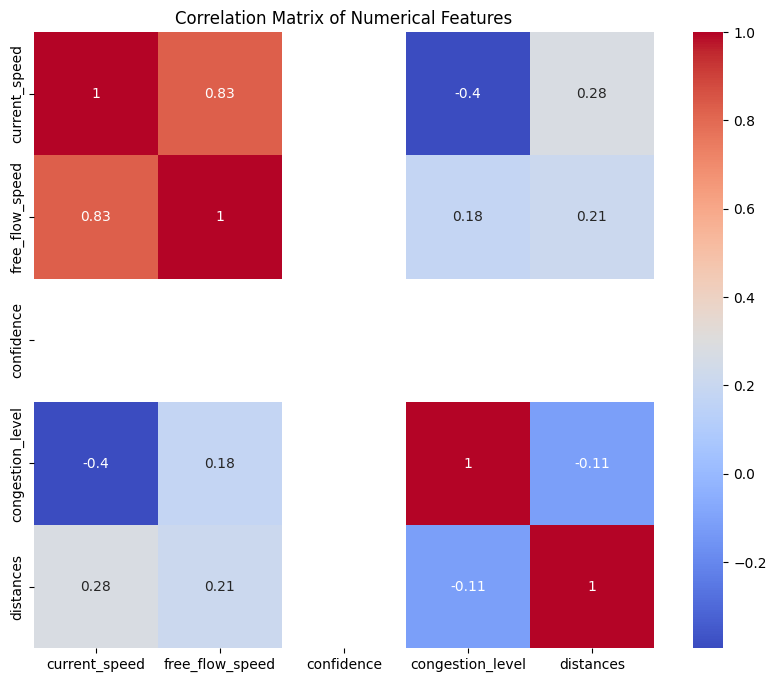

In [21]:
plt.figure(figsize=(10, 8))
corr_matrix = joined_data[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Geographic Distribution of Charging Stations

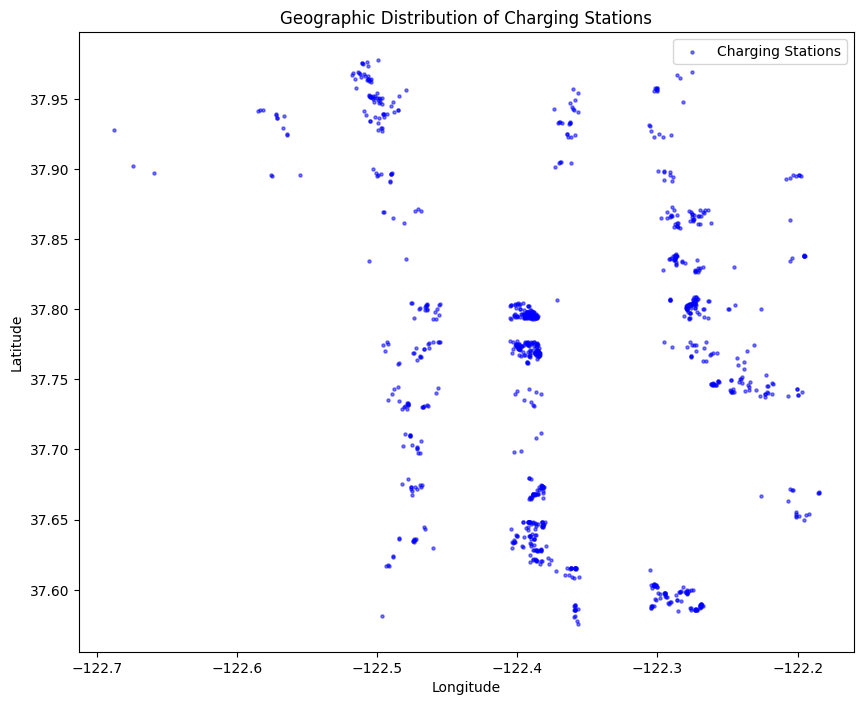

In [22]:
gdf = gpd.GeoDataFrame(joined_data, geometry=gpd.points_from_xy(joined_data.longitude, joined_data.latitude))

fig, ax = plt.subplots(figsize=(10, 10))
base = gdf.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.5, label='Charging Stations')
ax.set_title('Geographic Distribution of Charging Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()
plt.show()

# Traffic Congestion Analysis

<ipython-input-24-29e930ce422e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='congestion_category', data=joined_data, palette='viridis')


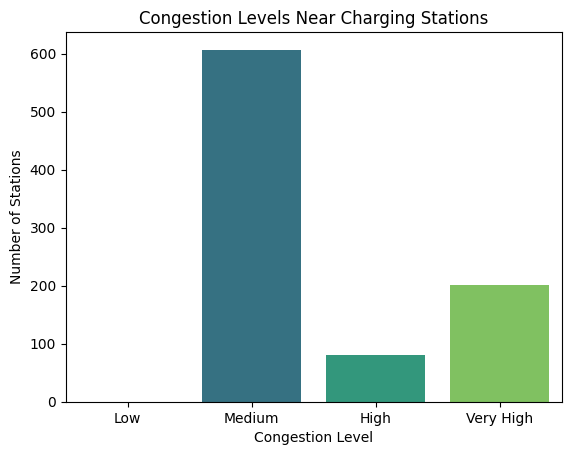

In [24]:
joined_data['congestion_category'] = pd.cut(joined_data['congestion_level'], bins=[0, 50, 100, 150, 200], labels=['Low', 'Medium', 'High', 'Very High'])

plt.figure()
sns.countplot(x='congestion_category', data=joined_data, palette='viridis')
plt.title('Congestion Levels Near Charging Stations')
plt.xlabel('Congestion Level')
plt.ylabel('Number of Stations')
plt.show()

#Relationship Between Traffic Speed and Charging Station Usage

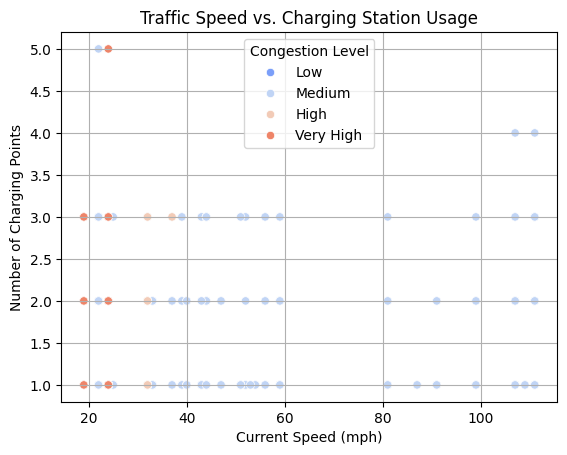

In [26]:
plt.figure()
sns.scatterplot(x='current_speed', y='num_points', hue='congestion_category', data=joined_data, palette='coolwarm', sizes=(20, 200))
plt.title('Traffic Speed vs. Charging Station Usage')
plt.xlabel('Current Speed (mph)')
plt.ylabel('Number of Charging Points')
plt.grid(True)
plt.legend(title='Congestion Level')
plt.show()

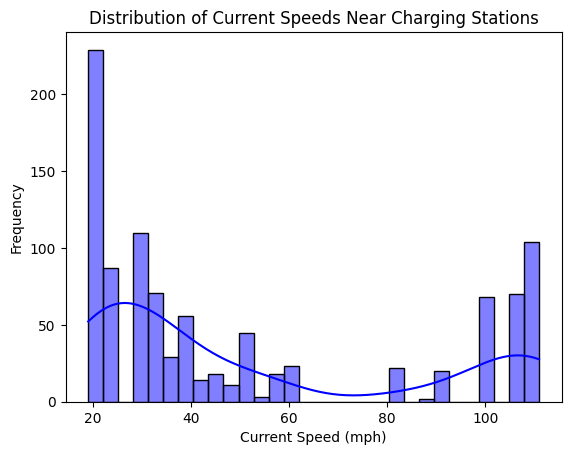

In [28]:
plt.figure()
sns.histplot(joined_data['current_speed'], bins=30, kde=True, color='blue')
plt.title('Distribution of Current Speeds Near Charging Stations')
plt.xlabel('Current Speed (mph)')
plt.ylabel('Frequency')
plt.show()

In [29]:
top_10_stations = joined_data.sort_values(by='num_points', ascending=False).head(10)

print(top_10_stations[['station_name', 'street_address', 'num_points']])

                                 station_name            street_address  \
392                            Marina Village  1001 Marina Village Pkwy   
16   Whole Foods San Francisco -Trinity Place            1185 Market St   
469                             ALCO STATIONS               165 13th St   
852                       Safeway - San Mateo       1655 El Camino Real   
205                      EVgo 350 Pacific Hub           350 Pacific Ave   
41                                 CCSF-SFMTA           1610 Geary Blvd   
425                           CITY OF OAKLAND                364 9th St   
968               Volkswagen Group of America        500-600 Clipper Dr   
419                           S SAN FRANCISCO           632 Forbes Blvd   
917                            Northgate Mall         5800 Northgate Dr   

     num_points  
392           5  
16            5  
469           4  
852           4  
205           4  
41            3  
425           3  
968           3  
419         

<ipython-input-30-270851dffdfd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_points', y='station_name', data=top_10_stations, palette='viridis')


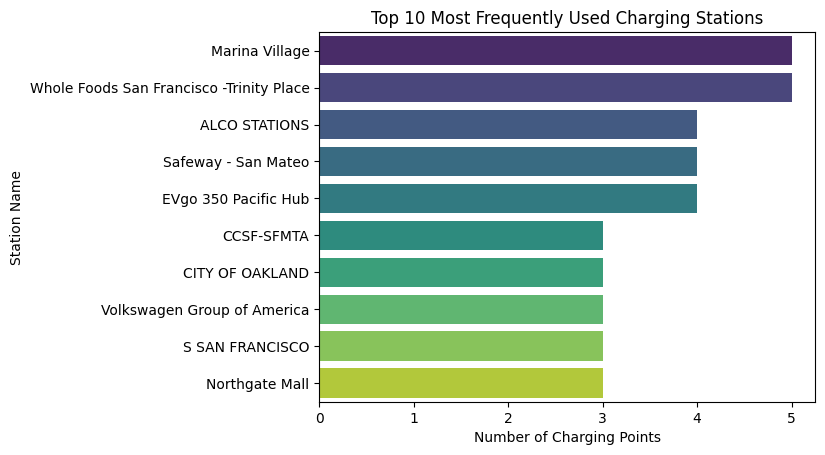

In [30]:
plt.figure()
sns.barplot(x='num_points', y='station_name', data=top_10_stations, palette='viridis')
plt.title('Top 10 Most Frequently Used Charging Stations')
plt.xlabel('Number of Charging Points')
plt.ylabel('Station Name')
plt.show()

# Determining the optimal number of clusters using the Elbow Method and Silhouette Score

In [34]:
inertia = []
silhouette_scores = []
K = range(50, 100)

In [35]:
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(features_scaled, labels)
    silhouette_scores.append(silhouette_avg)
    print(f'k = {k}, Silhouette Score = {silhouette_avg:.2f}')

k = 50, Silhouette Score = 0.59
k = 51, Silhouette Score = 0.59
k = 52, Silhouette Score = 0.59
k = 53, Silhouette Score = 0.60
k = 54, Silhouette Score = 0.60
k = 55, Silhouette Score = 0.61
k = 56, Silhouette Score = 0.61
k = 57, Silhouette Score = 0.61
k = 58, Silhouette Score = 0.61
k = 59, Silhouette Score = 0.62
k = 60, Silhouette Score = 0.61
k = 61, Silhouette Score = 0.62
k = 62, Silhouette Score = 0.62
k = 63, Silhouette Score = 0.62
k = 64, Silhouette Score = 0.63
k = 65, Silhouette Score = 0.63
k = 66, Silhouette Score = 0.64
k = 67, Silhouette Score = 0.64
k = 68, Silhouette Score = 0.65
k = 69, Silhouette Score = 0.66
k = 70, Silhouette Score = 0.67
k = 71, Silhouette Score = 0.68
k = 72, Silhouette Score = 0.67
k = 73, Silhouette Score = 0.68
k = 74, Silhouette Score = 0.69
k = 75, Silhouette Score = 0.69
k = 76, Silhouette Score = 0.69
k = 77, Silhouette Score = 0.69
k = 78, Silhouette Score = 0.69
k = 79, Silhouette Score = 0.70
k = 80, Silhouette Score = 0.70
k = 81, 

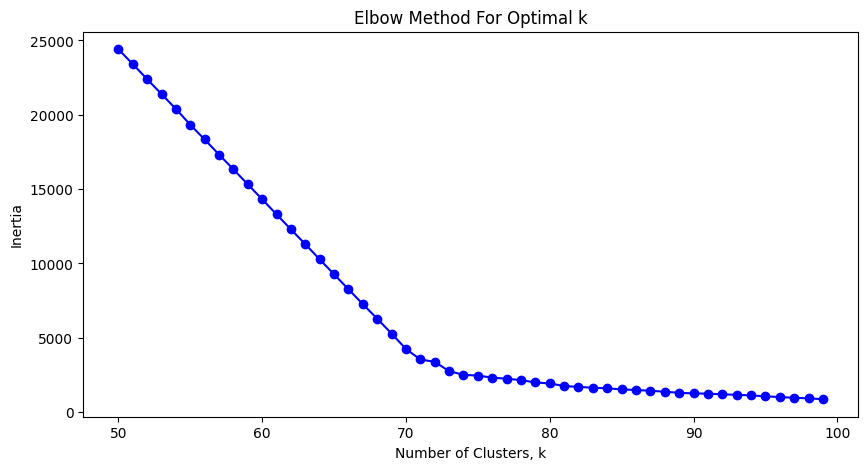

In [36]:
# Plotting the Elbow Method results
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

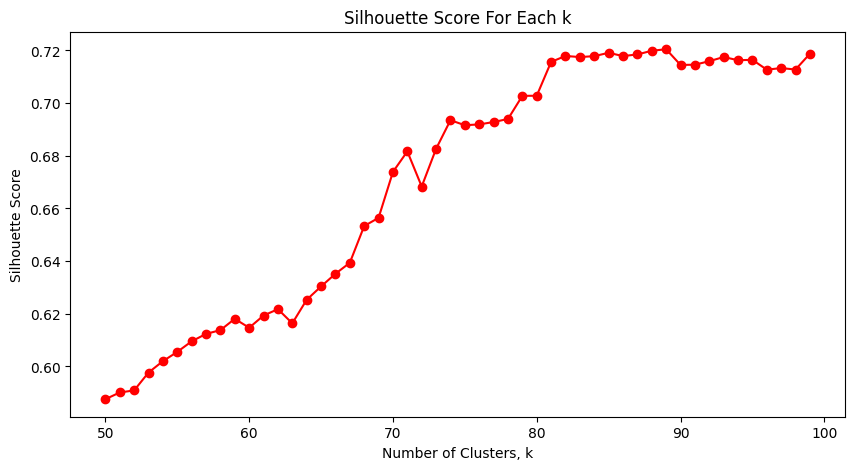

In [37]:
# Plotting the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Each k')
plt.show()

# Running KMeans with the optimal number of clusters

In [38]:
optimal_k = 81

final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(features_scaled)

In [39]:
joined_data['Cluster'] = cluster_labels

In [40]:
cluster_centers = final_kmeans.cluster_centers_

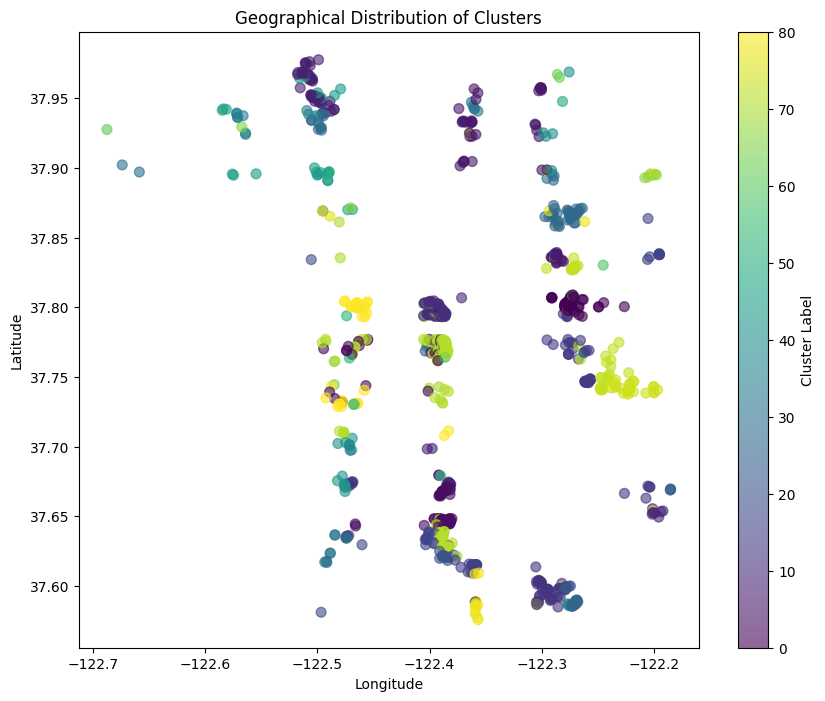

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(joined_data['longitude'], joined_data['latitude'], c=joined_data['Cluster'], cmap='viridis', s=50, alpha=0.6)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Clusters')
plt.show()

In [44]:
calinski_harabasz = calinski_harabasz_score(features_scaled, kmeans.labels_)
print("Calinski-Harabasz Index: {:.2f}".format(calinski_harabasz))

Calinski-Harabasz Index: 850.81


In [45]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin = davies_bouldin_score(features_scaled, kmeans.labels_)
print("Davies-Bouldin Index: {:.2f}".format(davies_bouldin))

Davies-Bouldin Index: 0.32


# PCA

Original Shape:  (1000, 7)
Reduced Shape:  (1000, 6)
Number of features needed to explain more than 90% of the dependent variance: 6


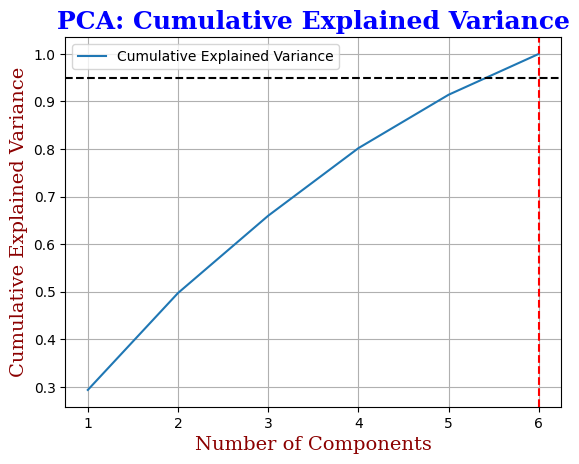

Condition Number of Original data: 42.53036884186227
Condition Number of Reduced data: 1.8498020046138792
Singular Values: [45.32047489 37.73758126 33.70257092 31.50797493 28.01641674 24.50017612]


In [54]:
from sklearn.decomposition import PCA

X = joined_data[['latitude', 'longitude', 'current_speed', 'free_flow_speed', 'congestion_level', 'num_points', 'distances']]
X = (X - X.mean()) / X.std()

pca = PCA(svd_solver="full", random_state=42, n_components=0.95)
X_pca = pca.fit_transform(X)

print("Original Shape: ", X.shape)
print("Reduced Shape: ", X_pca.shape)

print("Number of features needed to explain more than 90% of the dependent variance:",
    np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0] + 1, )

plt.figure()
plt.plot(
    np.arange(1, len(np.cumsum(pca.explained_variance_ratio_)) + 1, 1),
    np.cumsum(pca.explained_variance_ratio_), label="Cumulative Explained Variance",)
plt.xticks(np.arange(1, len(np.cumsum(pca.explained_variance_ratio_)) + 1, 1))
plt.title("PCA: Cumulative Explained Variance", fontsize=18, color='blue', fontfamily='serif', fontweight='bold')
plt.xlabel("Number of Components", fontsize=14, color='darkred', fontfamily='serif')
plt.ylabel("Cumulative Explained Variance", fontsize=14, color='darkred', fontfamily='serif')
plt.grid(True)
plt.axvline(x=(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0] + 1, ),
            color="red", linestyle="--")
plt.axhline(y=0.95, color="black", linestyle="--")
plt.legend()
plt.show()

# Conditional Number of Original and Reduced data
print('Condition Number of Original data:', np.linalg.cond(X))
print('Condition Number of Reduced data:', np.linalg.cond(X_pca))

print('Singular Values:', pca.singular_values_)


# visualize both the original locations of EV charging stations and the optimal placements suggested by KMeans clustering

In [59]:
import folium

centroid_df = joined_data.groupby('Cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

map_center_lat = joined_data['latitude'].mean()
map_center_lon = joined_data['longitude'].mean()
map = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=12, tiles='cartodbpositron')

for idx, row in joined_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Station: {row['station_name']}, Cluster: {row['Cluster']}"
    ).add_to(map)

for idx, row in centroid_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color='red', icon='star'),
        popup=f"Centroid for Cluster {row['Cluster']}"
    ).add_to(map)


In [58]:
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 200px; height: 100px;
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; <b>Legend</b> <br>
     &nbsp; Blue Circle : Existing Charging Station<br>
     &nbsp; Red Marker : Suggested New Location
</div>
'''

map.get_root().html.add_child(folium.Element(legend_html))
map